# Ages of Summer Olympic Games Athletes

#### A study of mean ages of Olympic athletes competing from 1896 to 2020. 
Author: Mark Richards (mark.thomas.richards@outlook.com)

- Data Source: https://www.kaggle.com/datasets/nitishsharma01/olympics-124-years-datasettill-2020
- Data Source License: CC0: Public Domain

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use("seaborn-darkgrid")

In [3]:
df_olympics_raw = pd.read_csv("Athletes_summer_games.csv")

## Business Task

The questions I'd like to address revolve around the __age__ of the athletes:

- Is there any change in the mean age of male and female competitors over the 124 years the data covers?
- Is there any change in the mean age of male and female medal winners over the same period?

## Cleaning

In [4]:
# Lets have a look at the data
df_olympics_raw.info(verbose=True)
df_olympics_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237673 entries, 0 to 237672
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  237673 non-null  int64  
 1   Name        237673 non-null  object 
 2   Sex         237673 non-null  object 
 3   Age         228484 non-null  float64
 4   Team        237673 non-null  object 
 5   NOC         237673 non-null  object 
 6   Games       237673 non-null  object 
 7   Year        237673 non-null  int64  
 8   Season      237673 non-null  object 
 9   City        237673 non-null  object 
 10  Sport       237673 non-null  object 
 11  Event       237673 non-null  object 
 12  Medal       36537 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 23.6+ MB


,Unnamed: 0,Name,Sex,Age,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,0,A Dijiang,M,24.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,1,A Lamusi,M,23.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,2,Gunnar Nielsen Aaby,M,24.0,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,3,Edgar Lindenau Aabye,M,34.0,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,26,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,Netherlands,NED,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,NaN


There are 237673 rows and we can see immediately that __9189 rows do not have an age__ (which is why this column is dtype float64 not int64, as int64 does not support NaN values). 

Since we need the age field for our analysis we seem to have little choice but to drop these rows, but before we do that we need to consider if there is any systematic reason age was not recorded: perhaps the earlier games did not record the age of their competitors? If so we may need to change the timeframe of the analysis. Lets check.

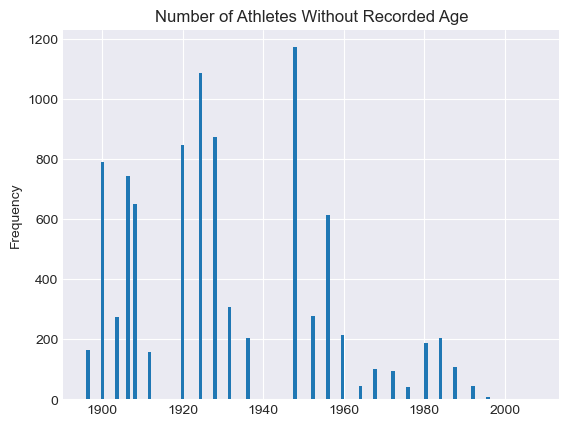

In [5]:
ch_bar_athletes_without_age = (
    df_olympics_raw
     .loc[df_olympics_raw["Age"].isna()]
     .loc[:,"Year"]
     .plot(
         kind="hist",
         bins=124,
         title="Number of Athletes Without Recorded Age")
)

It's not so clear cut: there are several specific Olympic games with higher rates of missing age data, so we cannot simply move the timeframe. We will have to exclude the rows, as we have no easy way to get the missing data (other than by looking up the dates of birth of the athletes and calculating their ages when competing). We would need to make this point if we were presenting this analysis.

We also need to check for __consistency of the age column__ in case there are any value errors which may skew any mean we calculate. 

In [6]:
(df_olympics_raw
    .loc[:, "Age"]
    .describe()
)

count    228484.000000
mean         25.746267
std           6.638720
min          10.000000
25%          21.000000
50%          25.000000
75%          29.000000
max          97.000000
Name: Age, dtype: float64

We seem to have children as young as 10 and people as old as 97 competing. Lets see how many of these outliers exist.

In [7]:
s_competitor_ages = (
    df_olympics_raw
    .loc[:, "Age"]
    .value_counts()
    .sort_index()
)

s_competitor_ages.head(10)

10.0       1
11.0       6
12.0      33
13.0     175
14.0     793
15.0    2066
16.0    3499
17.0    4715
18.0    7081
19.0    9944
Name: Age, dtype: int64

In [8]:
s_competitor_ages.tail(10)

74.0    12
75.0     4
76.0     7
77.0     2
80.0     3
81.0     2
84.0     1
88.0     3
96.0     1
97.0     1
Name: Age, dtype: int64

Not very many. The problem is that we have no a priori reason to assume these are errors: it is possible the children could be gymnasts, for instance, and the older people could also be valid competitors. 

In fact if we check the names of some of these competitors online it seems they did compete (and are famous as being the youngest Olympic competitors, for example). So these outliers need to stay.

We also need to __check the consistency of the medals column__.

In [9]:
(df_olympics_raw
    .loc[:, "Medal"]
    .value_counts()
)

Bronze    12276
Gold      12259
Silver    12002
Name: Medal, dtype: int64

And we only get the expected bronze, silver and gold. But we should replace the NaN values with "No Medal" during the cleaning process. 

Lets also check for __duplicate rows__.

In [10]:
(df_olympics_raw
     .duplicated()
     .sum()
)

0

And there are none.

__Important Point:__ During our analysis we also need to bear in mind that _the same athlete may have competed in multiple events_. Lets check this.

In [11]:
(df_olympics_raw
    .loc[:, "Name"]
    .value_counts()
)

Robert Tait McKenzie        58
Heikki Ilmari Savolainen    39
Joseph "Josy" Stoffel       38
Ioannis Theofilakis         36
Takashi Ono                 33
                            ..
Anita Kobu (Nner-)           1
Agnieszka Kobus              1
Elias Kobti                  1
Mary Elizabeth Koboldt       1
Panagiotis Manias            1
Name: Name, Length: 127751, dtype: int64

And yes, some athletes have competed in many events and so they will be represented in multiple rows of the data. We will need to account for this during our analysis. 

Lets __define and run our cleaning function__ and then check it has worked correctly.

In [12]:
def olympic_cleaning(df):
    """Clean 'Athletes_summer_games.csv' dataset."""
    return (
        df
        .dropna(subset=["Age"])
        .fillna("No Medal")     # The only remaining NaN values are in the Medal column
    )

df_olympics_clean = olympic_cleaning(df_olympics_raw)

In [13]:
df_olympics_clean.info(verbose=True)
df_olympics_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228484 entries, 0 to 237672
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  228484 non-null  int64  
 1   Name        228484 non-null  object 
 2   Sex         228484 non-null  object 
 3   Age         228484 non-null  float64
 4   Team        228484 non-null  object 
 5   NOC         228484 non-null  object 
 6   Games       228484 non-null  object 
 7   Year        228484 non-null  int64  
 8   Season      228484 non-null  object 
 9   City        228484 non-null  object 
 10  Sport       228484 non-null  object 
 11  Event       228484 non-null  object 
 12  Medal       228484 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 24.4+ MB


,Unnamed: 0,Name,Sex,Age,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,0,A Dijiang,M,24.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No Medal
1,1,A Lamusi,M,23.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No Medal
2,2,Gunnar Nielsen Aaby,M,24.0,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,No Medal
3,3,Edgar Lindenau Aabye,M,34.0,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,26,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,Netherlands,NED,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,No Medal


And this checks: we have 228484 rows (same as the non-null rows for "Age") and no missing values.

## Analysis

The questions we want to answer using this data are:
    
- Is there any change in the mean age of male and female competitors over the 124 years the data covers?
- Is there any change in the mean age of male and female medal winners over the same period?

### Mean Age of Male and Female Competitors

As mentioned above, we need to account for individual athletes being represented multiple times in the data. 

We can pivot the data to obtain a list of unique combinations of year, name, age and sex.

In [14]:
df_mean_age_data_all = (
    df_olympics_clean
    .pivot_table(
        index=["Year", "Name", "Age", "Sex"],
        )
    .drop("Unnamed: 0", axis=1)
    .reset_index()
)

df_mean_age_data_all.head()

,Year,Name,Age,Sex
0,1896,Alajos (Aljoz) Szokoly (-Szokol),24.0,M
1,1896,Albert Clinton Tyler,24.0,M
2,1896,Albin Georges Lermusiaux,21.0,M
3,1896,Alexander Viggo Jensen,21.0,M
4,1896,Alfrd (Arnold-) Hajs (Guttmann-),18.0,M


Now we can split this by gender and group it.

In [15]:
def mean_age_by_gender(df, gender):
    """Selects Sex == gender, groups by year, aggregates by mean."""
    return (
        df
        .query("Sex == @gender")
        .loc[:, ["Year", "Age"]]
        .groupby("Year")
        .agg("mean")
    )

# male and female mean data
df_mean_age_data_male = mean_age_by_gender(df_mean_age_data_all, "M")
df_mean_age_data_female = mean_age_by_gender(df_mean_age_data_all, "F")

# combined male and female data on index (Year)
df_mean_age_data_combined = df_mean_age_data_male.join(
    df_mean_age_data_female,
    lsuffix="_Mean_M",
    rsuffix="_Mean_F")

df_mean_age_data_combined.head()

,Age_Mean_M,Age_Mean_F
Year,,
1896,23.138889,NaN
1900,28.237942,29.4375
1904,26.629032,48.8000
1906,25.625641,23.5000
1908,26.676882,34.5000


Lets look at the results.

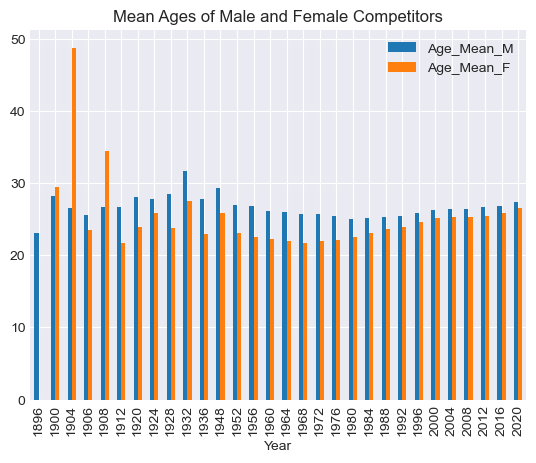

In [16]:
ch_bar_mean_age_data_combined = df_mean_age_data_combined.plot(
    kind="bar",
    title="Mean Ages of Male and Female Competitors"
)

Ignoring the 1896 games (the first games in modern times, so possibly anomalous), for men we see a decline in mean age from 1900 to 1906, then a gradual increase peaking in 1936, followed by another gradual decline reaching a minimum in 1980, then consistently increasing as we approach 2020.

The trend for female competitors has a lot of variability in the early games, reaching an all time low in 1912, then increasing up to 1932 before a gradual decline with a minimum in 1968, followed by a consistent gradual increase up to almost parity with male competitors in 2020. 

It would be interesting to consider why there is a female minimum in 1968 but a male minimum in 1980 - they are out of sync.

It seems to be that although female competitors have consistently lower ages than male competitors overall, there is a clear upward trend bringing them together, although the male competitors are also increasing in mean age at the same time. 

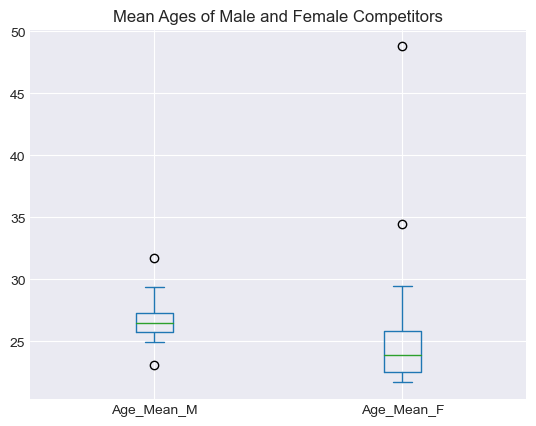

In [17]:
ch_box_mean_age_data_combined = df_mean_age_data_combined.plot(
    kind="box",
    title="Mean Ages of Male and Female Competitors"
)

In [18]:
df_mean_age_data_combined.describe()

,Age_Mean_M,Age_Mean_F
count,30.000000,29.000000
mean,26.662363,25.339318
std,1.564981,5.251836
min,23.138889,21.702046
25%,25.732378,22.530797
50%,26.522147,23.928571
75%,27.318247,25.829060
max,31.734177,48.800000


Over all the games we can see that the means, IQR and standard deviation of male and female competitors are substantially different. 

## Mean Age of Male and Female Medal Winners

To examine just the medal winners, we need to filter them out from the original data set and then repeat the same analysis.

In [19]:
df_medal_winners = (
    df_olympics_clean
    .query("Medal != 'No Medal'")
)

In [20]:
df_medals_mean_age_data_all = (
    df_medal_winners
    .pivot_table(
        index=["Year", "Name", "Age", "Sex"],
        )
    .drop("Unnamed: 0", axis=1)
    .reset_index()
)

In [21]:
# male and female mean data
df_medals_mean_age_data_male = mean_age_by_gender(df_medals_mean_age_data_all, "M")
df_medals_mean_age_data_female = mean_age_by_gender(df_medals_mean_age_data_all, "F")

# combined male and female data on index (Year)
df_medals_mean_age_data_combined = df_medals_mean_age_data_male.join(
    df_medals_mean_age_data_female,
    lsuffix="_Mean_M",
    rsuffix="_Mean_F")

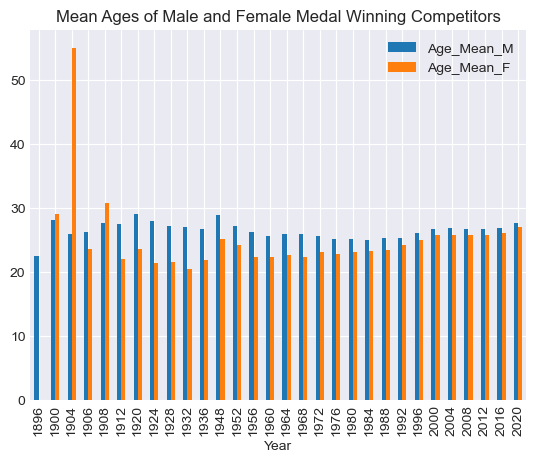

In [22]:
ch_bar_medals_mean_age_data_combined = df_medals_mean_age_data_combined.plot(
    kind="bar",
    title="Mean Ages of Male and Female Medal Winning Competitors"
)

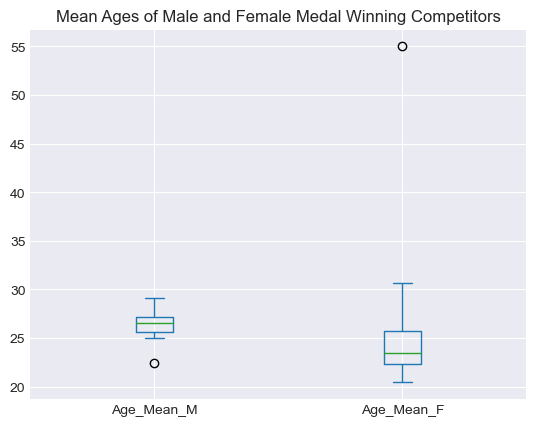

In [23]:
ch_box_medals_mean_age_data_combined = df_medals_mean_age_data_combined.plot(
    kind="box",
    title="Mean Ages of Male and Female Medal Winning Competitors"
)

In [24]:
df_medals_mean_age_data_combined.describe()

,Age_Mean_M,Age_Mean_F
count,30.000000,29.000000
mean,26.439417,25.101484
std,1.304914,6.183595
min,22.438596,20.442308
25%,25.658104,22.343137
50%,26.576812,23.500000
75%,27.119236,25.695707
max,29.072572,55.000000
